**Jupyter notebooks** are a great way to
* document the analytics workflow
* use best in class tools i.e. take a mature approach for delivering excellent workproducts
* automate workflows that need to be repeated - parameterize workflows and schedule notebooks
* convert the raw notebook into a other formats (pdf, latex, html, .py script or a revealjs slidedeck

Load python packages needed for this demo

In [1]:
import pandas as pd
import requests
import ast
from IPython.display import display, display_pretty, Javascript, HTML
from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts
import random
import sas7bdat
import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Load the extension that enables SAS magic!

In [2]:
%load_ext saspy.sas_magic

Using SAS Config named: default


Confirm if the magic commands are available

In [3]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %install_default_config  %install_ext  %install_profiles  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%IML  %%OPTMODEL  %%SAS  %%SVG  %%bash  %%capture  %%debug  %%file  %%html 

Lets check if **SAS Magic** Works

In [4]:
%%SAS 
proc print data=sashelp.class;
run;

Obs,Name,Sex,Age,Height,Weight
1,Alfred,M,14,69.0,112.5
2,Alice,F,13,56.5,84.0
3,Barbara,F,13,65.3,98.0
4,Carol,F,14,62.8,102.5
5,Henry,M,14,63.5,102.5
6,James,M,12,57.3,83.0
7,Jane,F,12,59.8,84.5
8,Janet,F,15,62.5,112.5
9,Jeffrey,M,13,62.5,84.0
10,John,M,12,59.0,99.5


you can install other python packages this way --
* !pip install numpy
* !pip install pandas
* !pip freeze

Check a SAS library to look for available data sets

In [5]:
%%SAS
proc sql;
select *
  from dictionary.tables
  where libname = 'SASHELP' and memtype = 'DATA'
  order by memname ;
quit ;
run;

Library Name,Member Name,Member Type,DBMS Member Type,Data Set Label,Data Set Type,Date Created,Date Modified,Number of Physical Observations,Observation Length,Number of Variables,Type of Password Protection,Compression Routine,Encryption,Number of Pages,Size of File,Percent Compression,Reuse Space,Bufsize,Number of Deleted Observations,Number of Logical Observations,Longest variable name,Longest label,Maximum number of generations,Generation number,Data Set Attributes,Type of Indexes,Data Representation,Name of Collating Sequence,Sorting Type,Charset Sorted By,Requirements Vector,Data Representation Name,Data Encoding,Audit Trail Active?,Audit Before Image?,Audit Admin Image?,Audit Error Image?,Audit Data Image?,Number of Character Variables,Number of Numeric Variables
SASHELP,AACOMP,DATA,,,DATA,17JUN15:18:23:43,17JUN15:18:23:43,2020,1269,4,---,CHAR,NO,6,458752,85,no,65536,0,2020,6,0,0,.,ON,COMPOSITE,NATIVE,,SK,ANSI,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,3,1
SASHELP,AARFM,DATA,,,DATA,27MAY15:20:58:48,27MAY15:20:58:48,61,1269,4,---,CHAR,NO,3,262144,0,no,65536,0,61,6,0,0,.,ON,COMPOSITE,NATIVE,,SK,ANSI,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,3,1
SASHELP,ADSMSG,DATA,,,MSGFILE,27MAY15:21:07:18,27MAY15:21:07:18,426,280,6,---,NO,NO,3,262144,0,no,65536,0,426,8,0,0,.,ON,SIMPLE,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,4,2
SASHELP,AFMSG,DATA,,,MSGFILE,27MAY15:20:57:04,27MAY15:20:57:04,1090,288,6,---,NO,NO,6,458752,0,no,65536,0,1090,8,0,0,.,ON,SIMPLE,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,4,2
SASHELP,AIR,DATA,,airline data (monthly: JAN49-DEC60),DATA,27MAY15:21:10:50,27MAY15:21:10:50,144,16,2,---,NO,NO,1,131072,0,no,65536,0,144,4,40,0,.,ON,,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,0,2
SASHELP,APPLIANC,DATA,,Sales time series for 24 appliances by cycle,DATA,27MAY15:21:10:41,27MAY15:21:10:41,156,200,25,---,NO,NO,1,131072,0,no,65536,0,156,8,19,0,.,ON,,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,0,25
SASHELP,ASSCMGR,DATA,,,DATA,27MAY15:21:25:09,27MAY15:21:25:09,402,592,19,---,NO,NO,4,327680,0,no,65536,0,402,8,0,0,.,ON,,NATIVE,,S,ANSI,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,12,7
SASHELP,ATTRLOOKUP,DATA,,,DATA,29JUL15:18:17:07,29JUL15:18:17:07,3476,704,13,---,NO,NO,38,2555904,0,no,65536,0,3476,7,19,0,.,ON,,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,12,1
SASHELP,BASEBALL,DATA,,1986 Baseball Data,DATA,27MAY15:21:40:22,27MAY15:21:40:22,322,216,24,---,NO,NO,2,196608,0,no,65536,0,322,9,27,0,.,ON,,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,6,18
SASHELP,BEI,DATA,,Tropical Rainforest Trees and Covariates,DATA,27MAY15:21:40:20,27MAY15:21:40:20,24205,192,24,---,NO,NO,72,4784128,0,no,65536,0,24205,11,0,0,.,ON,,NATIVE,,,,181F101133220033330102310133012333001C0000200301,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",us-ascii ASCII (ANSI),no,no,no,no,no,0,24


Let's do something with the cars dataset - but before that, let's check it out

In [6]:
%%SAS
proc print data = sashelp.cars(obs =5);
run;

Obs,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
1,Acura,MDX,SUV,Asia,All,"$36,945","$33,337",3.5,6,265,17,23,4451,106,189
2,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$23,820","$21,761",2.0,4,200,24,31,2778,101,172
3,Acura,TSX 4dr,Sedan,Asia,Front,"$26,990","$24,647",2.4,4,200,22,29,3230,105,183
4,Acura,TL 4dr,Sedan,Asia,Front,"$33,195","$30,299",3.2,6,270,20,28,3575,108,186
5,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$43,755","$39,014",3.5,6,225,18,24,3880,115,197


In [7]:
%%SAS
proc setinit;
run;

#### This is great! We'll dabble with ETS later, let's test out some basic STAT procedures
May be some [Correlations](http://support.sas.com/documentation/cdl/en/procstat/63104/HTML/default/viewer.htm#procstat_corr_sect004.htm) and [Regressions](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_reg_sect007.htm)

In [8]:
%%SAS
proc corr data = sashelp.cars;
var MSRP Invoice EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length;
run;


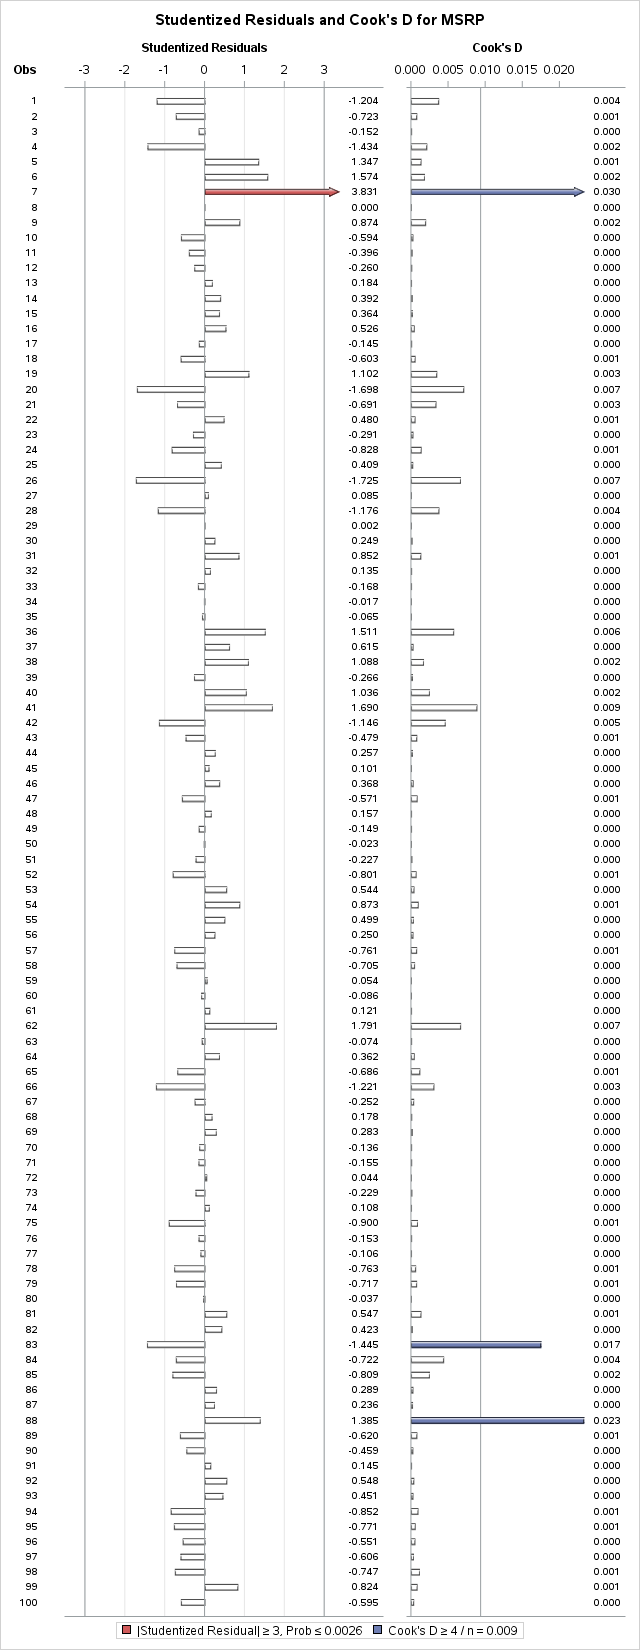
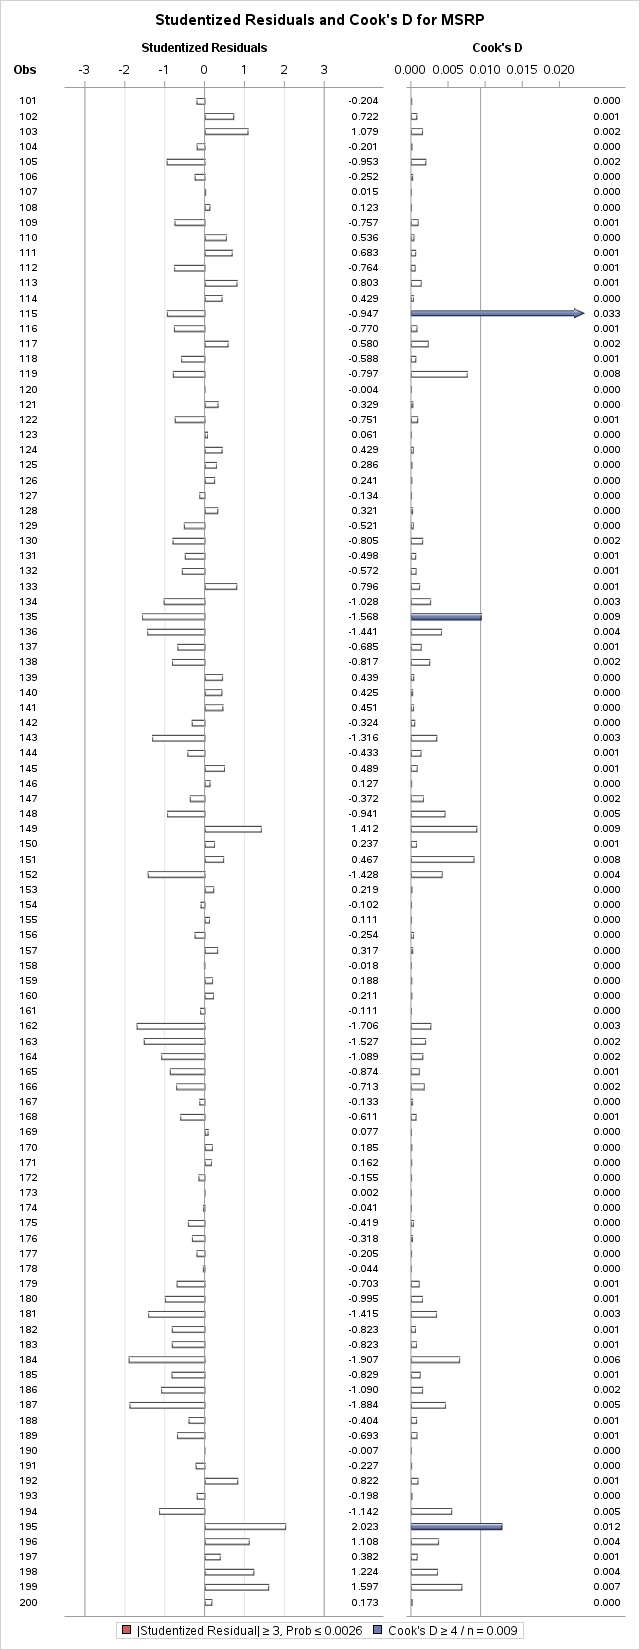
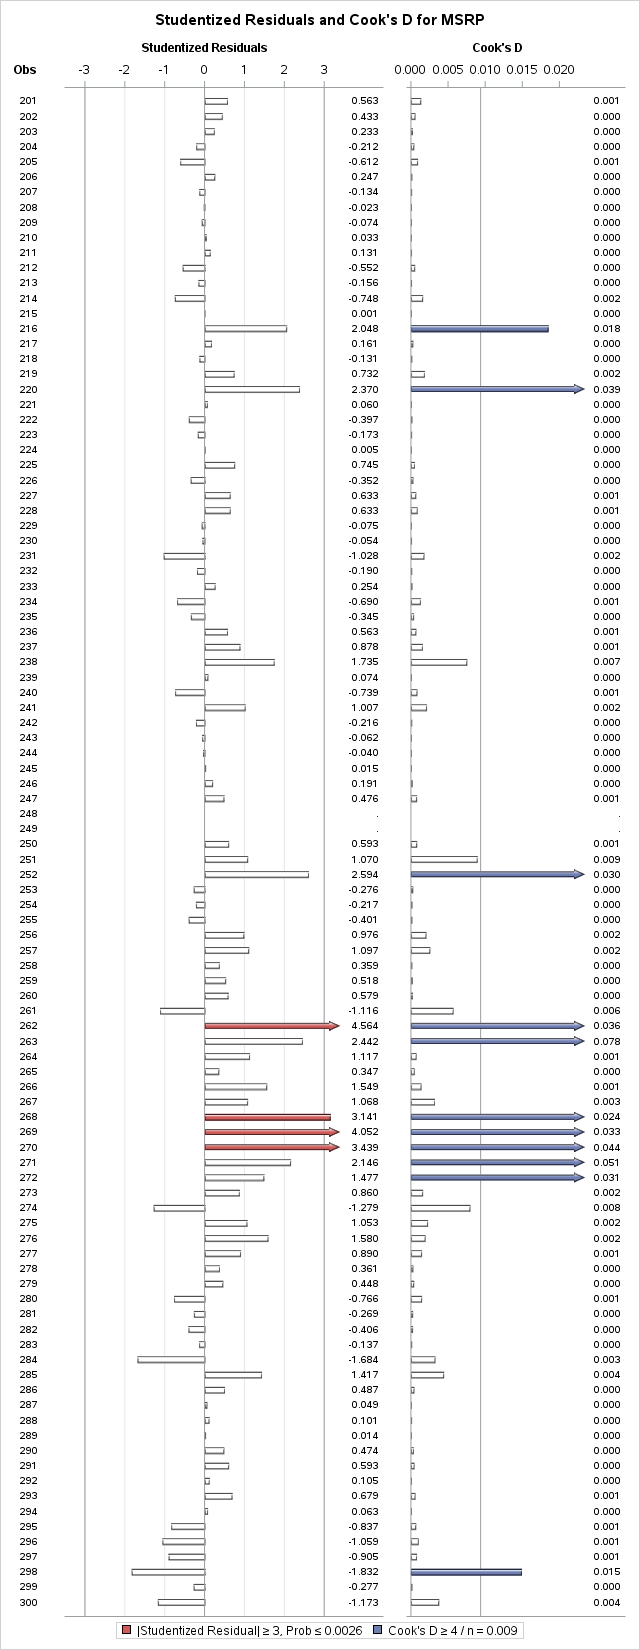
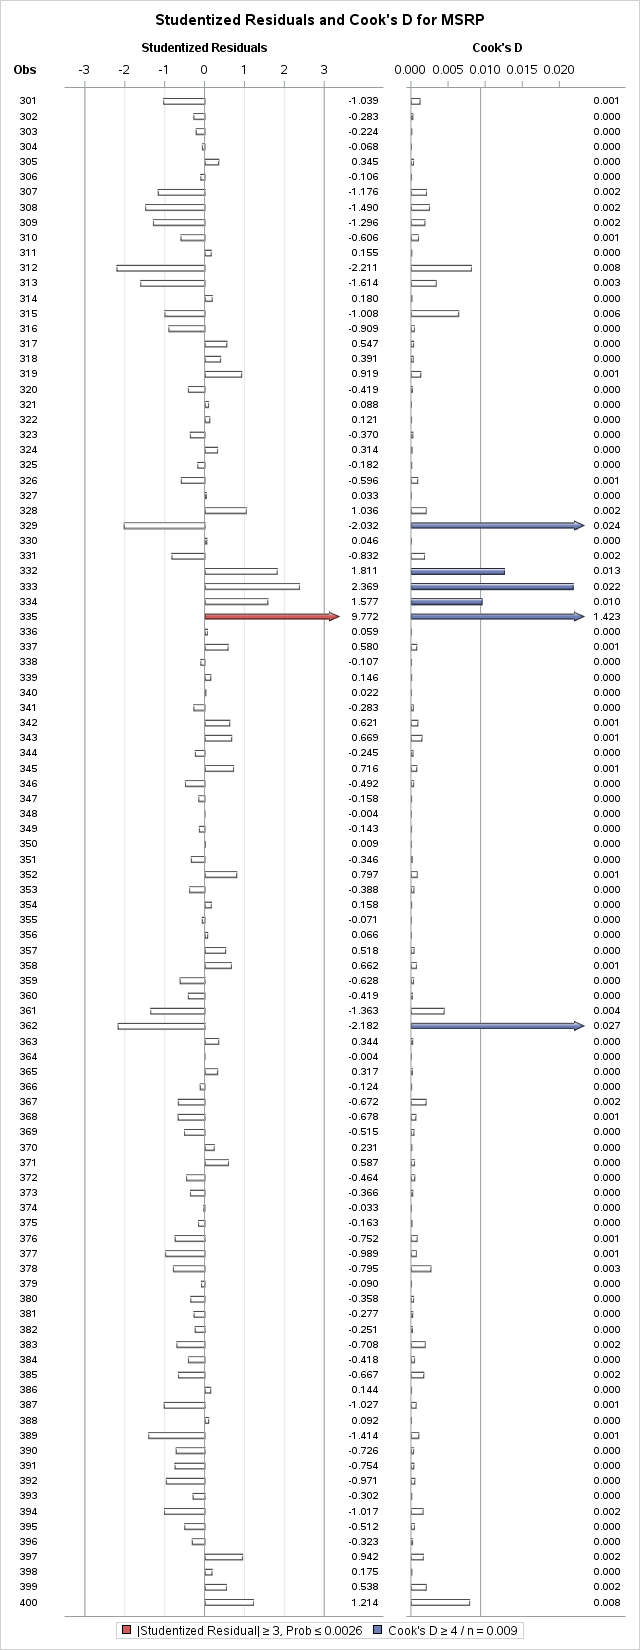
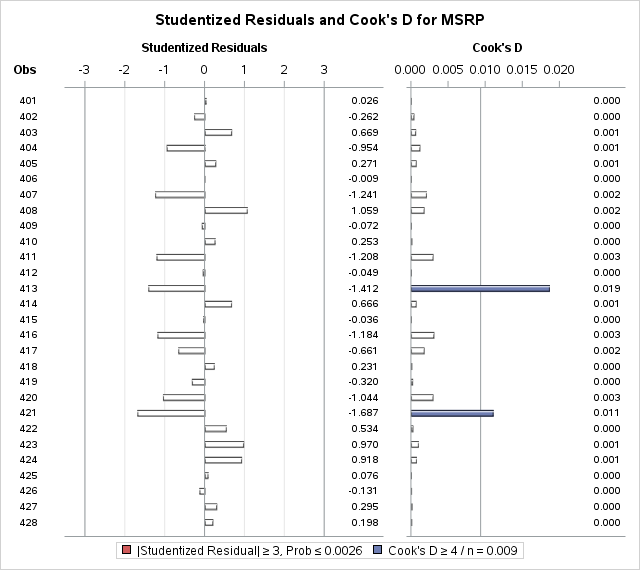
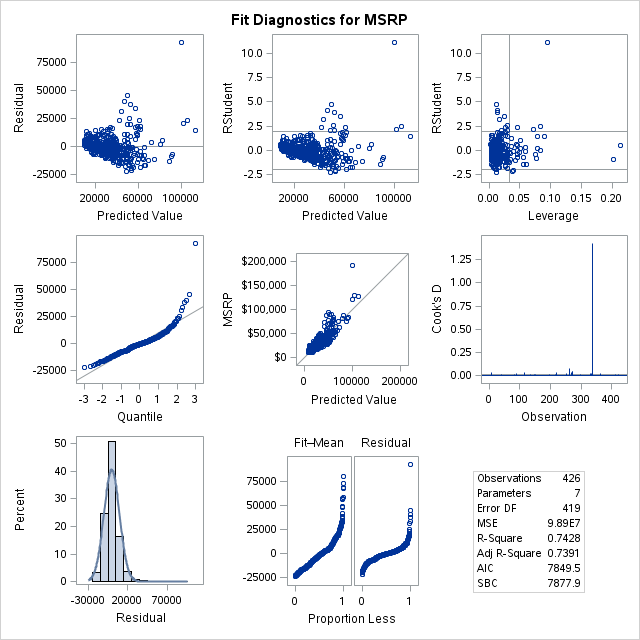
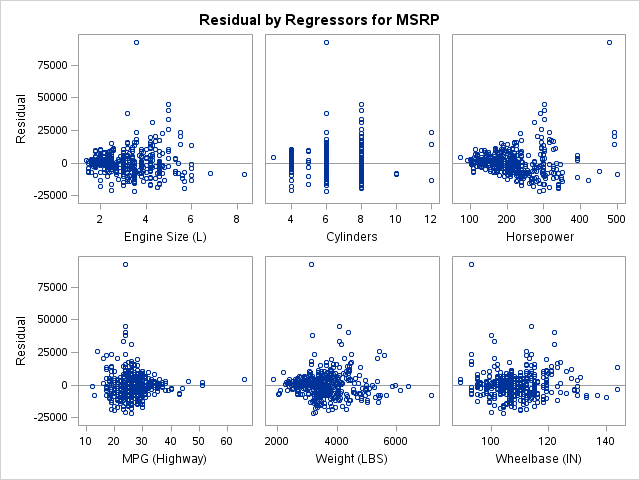

In [10]:
%%SAS
proc reg data = sashelp.cars plots=diagnostics(stats=(default aic sbc));
model MSRP = EngineSize Cylinders Horsepower MPG_City MPG_Highway Weight Wheelbase Length / selection=stepwise
run;

Obviously, you can transform, check for normality..etc.. but this is cake! Would it be awesome*r* if we demonstrated the power of running SAS on the jupyter notebook by getting some data from the web and using SAS to generate some forecasts and finally visualize the forecasts?

All without leaving the jupyter notebook!

Let's see some **SAS magic** at work for a forecasting problem !!

We're going to need some python modules before we start so lets that out of the way

In [11]:
#!pip install requests

A short detour here as we prep the data

We're going to get some data from google trends. Note: *google does not provide an official Public API for Google Trends*

In [12]:
import sys
print("The version of Python on the VM is {}".format(sys.version))

The version of Python on the VM is 3.5.2 |Anaconda 4.1.1 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [13]:

class gTrends_Parser(object):
    def __init__(self,google_terms):
        #self.terms_tuple = (google_terms.split(','))
        self.actual_terms = google_terms #[x.lstrip(' ') for x in self.terms_tuple]
        self.column_count = len(self.actual_terms)
        self.full_blob_dict = None
        self.table_data_dict = None
        self.column_name_dict = None
        self.row_value_dict = None
        self.raw_frame = None
        self.final_frame = None
        self.dummy_frame = None
        return

    def _get_gtrends_blob(self,actual_terms):
        """the function returns a dictionary that contains the returned js blob and
        another parsed dictionary that contains just the table results after
        collecting the data from google trends
        Ex:- resp_blob, table_dict = get_gtrends_blob(actual_terms)
        """
        content_resource = """https://www.google.com/trends/fetchComponent?q={0}&cid=TIMESERIES_GRAPH_0&export=3""".format(self.actual_terms)
        r = requests.get(content_resource)   #get request to the identified resource
        response = r.content   # push content into a seperate variable
        if 'null' in str(response):
            response = response.decode().replace(","*self.column_count +'{"v":null}',',{"v":0.0,"f":""}'*self.column_count)
        blob_dict = ast.literal_eval(response.split('setResponse(')[1].rstrip()[:-2].replace('new Date', ''))   #returns parsed js blob
        table_dict = blob_dict['table']['rows']  #subset the blob to just collect the actual data
        return blob_dict,table_dict

    def get_raw_data_blobs(self):
        self.full_blob_dict, self.table_data_dict = self._get_gtrends_blob(self.actual_terms)
        return self.full_blob_dict, self.table_data_dict

    @staticmethod
    def _read_column_names(whole_blob_obj,column_count):
        """the function takes the whole blob obj and the column count variable
        and returns a dictionary of column names as captured on google trends
        Ex:- column_name_dict = _read_column_names(resp_blob,column_count)
        """
        columns={}
        for i in range(column_count+1):
            columns[i]=whole_blob_obj['table']['cols'][i]['label']
        return columns

    def get_column_names(self):
        self.column_name_dict = self._read_column_names(self.full_blob_dict,self.column_count)
        return self.column_name_dict

    @staticmethod
    def _read_rows(tbl_obj,column_count):
        """the function takes the table dictonary object and the column count variable
        to return a row data on the table in a dictonary format
        Ex:- my_rows = _read_row_values(table_dict,column_count)
        """
        rows={}
        for row_ix in range(len(tbl_obj)):
            columns ={}
            for i in range(column_count+1):
                columns[i]=tbl_obj[row_ix]['c'][i]['v']
            rows[row_ix]=columns
        return rows

    def get_row_values(self):
        self.row_value_dict = self._read_rows(self.table_data_dict,self.column_count)
        return self.row_value_dict

    @staticmethod
    def _generate_dataframe_obj(col_names_obj,row_values_obj):
        """func takes in column names dict and row value dict to mash up
        a pandas dataframe
        Ex:- my_frame= generate_dataframe_obj(column_name_dict,my_rows)
        """
        df = pd.DataFrame.from_dict(row_values_obj,orient='index')
        if not(len(col_names_obj)==len(df.columns)):
            assert('Too many column names or data frame columns. verify!')
        else:
            df.columns = col_names_obj.values()
        return df

    def get_data_frame_raw(self):
        self.raw_frame = self._generate_dataframe_obj(self.column_name_dict,self.row_value_dict)
        return self.raw_frame

    @staticmethod
    def _get_dates(dataframe):

        """
        Takes a raw gTrends Dframe - the output of the generate_dataframe_obj method and
        returns a usable dictionary of date strings.
        Note this func typically invoked via the gdate_to_pydate function. Check docstring
        for gdate_to_pydate function
        """
        pdate ={}
        for i in range(len(dataframe.Date)):
            year = str(dataframe.Date[i][0])
            month = str(dataframe.Date[i][1]+1)
            cal_date = str(dataframe.Date[i][2])
            pdate[i]= year+'-'+month+'-'+cal_date
        return pdate


    def _gdate_to_pydate(self,dframe):

        """
        Takes a raw gTrends Dframe - and returns a processed Data Frame with dates in
        string and manipulatable python date format. Uses get_dates method to process
        raw dates
        Ex:- my_processed_frame = gdate_to_pydate(my_frame)
        """
        dframe['str_date'] = pd.Series(self._get_dates(dframe), index = dframe.index)
        dframe['cal_date'] = pd.to_datetime(dframe['str_date'])
        return dframe

    def get_data_frame_processed(self):
        self.final_frame = self._gdate_to_pydate(self.raw_frame)
        return self.final_frame

Let's get some data about Amazon and Ebay

In [14]:
# Next we define the terms and call the parser
google_terms = ['amazon','ebay']
myParserObject = gTrends_Parser(google_terms)

In [15]:
print(google_terms,len(google_terms))

['amazon', 'ebay'] 2


In [16]:
# Running a bunch of parser methods
myParserObject.get_raw_data_blobs()  # Sends a get request and collects the data

myParserObject.full_blob_dict  # has the entire data blob as a raw un-processed object

myParserObject.table_data_dict  # has just the raw data

myParserObject.get_column_names()  # parses and displays the column names

myParserObject.get_row_values()  # parses and displays row values

myParserObject.get_data_frame_raw()  # reads and converts data into a raw data frame - Dates still need to be processed

final_frame = myParserObject.get_data_frame_processed() # this adjusts the date to match actual google trends data

Now let's take a look at our data

In [17]:
final_frame = final_frame.iloc[:-1]  #drop the last month- as it will be incomplete
final_frame.tail()#confirm there are no incomplete months

,Date,amazon,ebay,str_date,cal_date
146,"(2016, 2, 1)",69.000,51.000,2016-3-1,2016-03-01
147,"(2016, 3, 1)",69.000,50.000,2016-4-1,2016-04-01
148,"(2016, 4, 1)",68.000,47.000,2016-5-1,2016-05-01
149,"(2016, 5, 1)",70.000,47.000,2016-6-1,2016-06-01
150,"(2016, 6, 1)",78.000,48.000,2016-7-1,2016-07-01


Too many date columns - Let's clean it up and visualize just to confirm

In [18]:
final_frame = final_frame.drop(['Date','str_date'], 1)

In [19]:
final_frame = final_frame.set_index(final_frame['cal_date'])
display_charts(final_frame, title="Google Trends Data",zoom="xy")

That looks great - How about mashing up some dummy data and generating some super cool SAS forecasts?

In [20]:
final_frame['amazon_visits']=0
final_frame['ebay_visits']=0
def dummy_data_builder(frame,scalar=1000000):
    for i in range(len(frame)):
        frame['amazon_visits'][i] = frame['amazon'][i] *(scalar + random.randint(1,10000))
        frame['ebay_visits'][i] = frame['ebay'][i] *(scalar + random.randint(1,10000))
    return frame

sas_frame = dummy_data_builder(final_frame)  # to see if we get the dummy data



In [21]:
#sas_frame.head()  #to check if we get the data as planned
display_charts(sas_frame, title="Made-Up Visit Data",zoom="xy")
#Notice the difference in the holiday peaks between eBay and Amazon -pretty cool!!

We now need to move this data into SAS

In [22]:
!pwd #You can also write unix commands
sas_frame.to_csv('dummy_data.csv')  #writing the data frame to a csv file
!ls

/home/sasdemo
Anaconda3-4.1.1-Linux-x86_64.sh  myfile.txt
dummy_data.csv			 myPythonNotebook.ipynb
ESP_code			 myPythonNotebook.slides.html
ESP_logs			 sasuser.v94
Load_SAS_from_Python.ipynb	 testsas.ipynb
mail



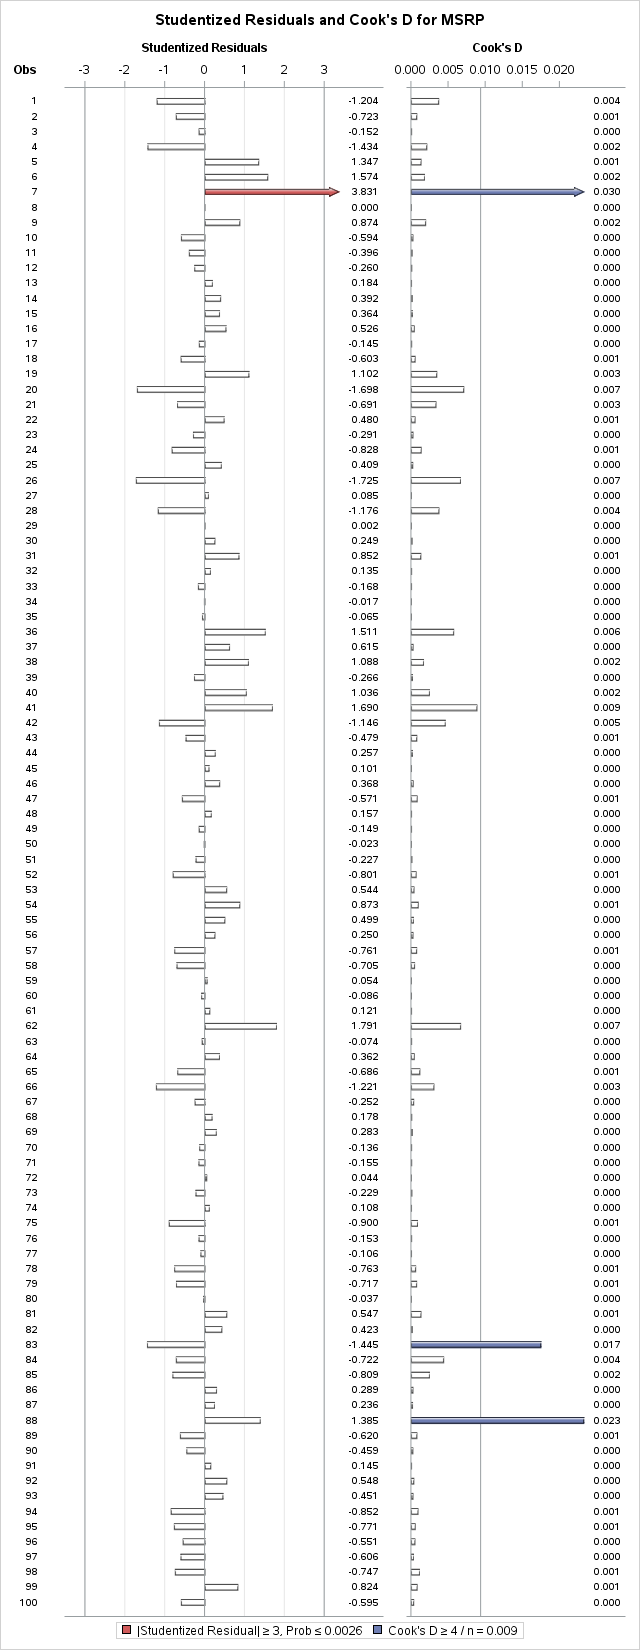
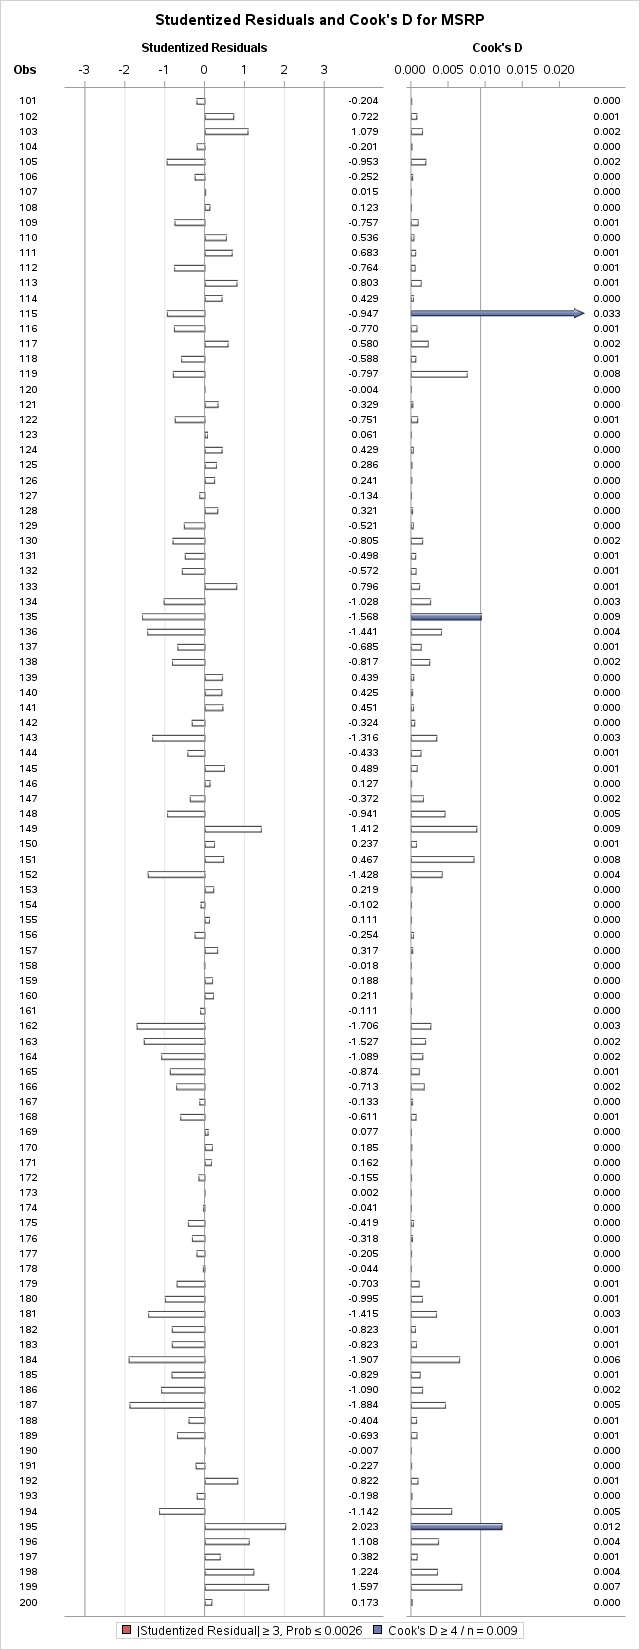
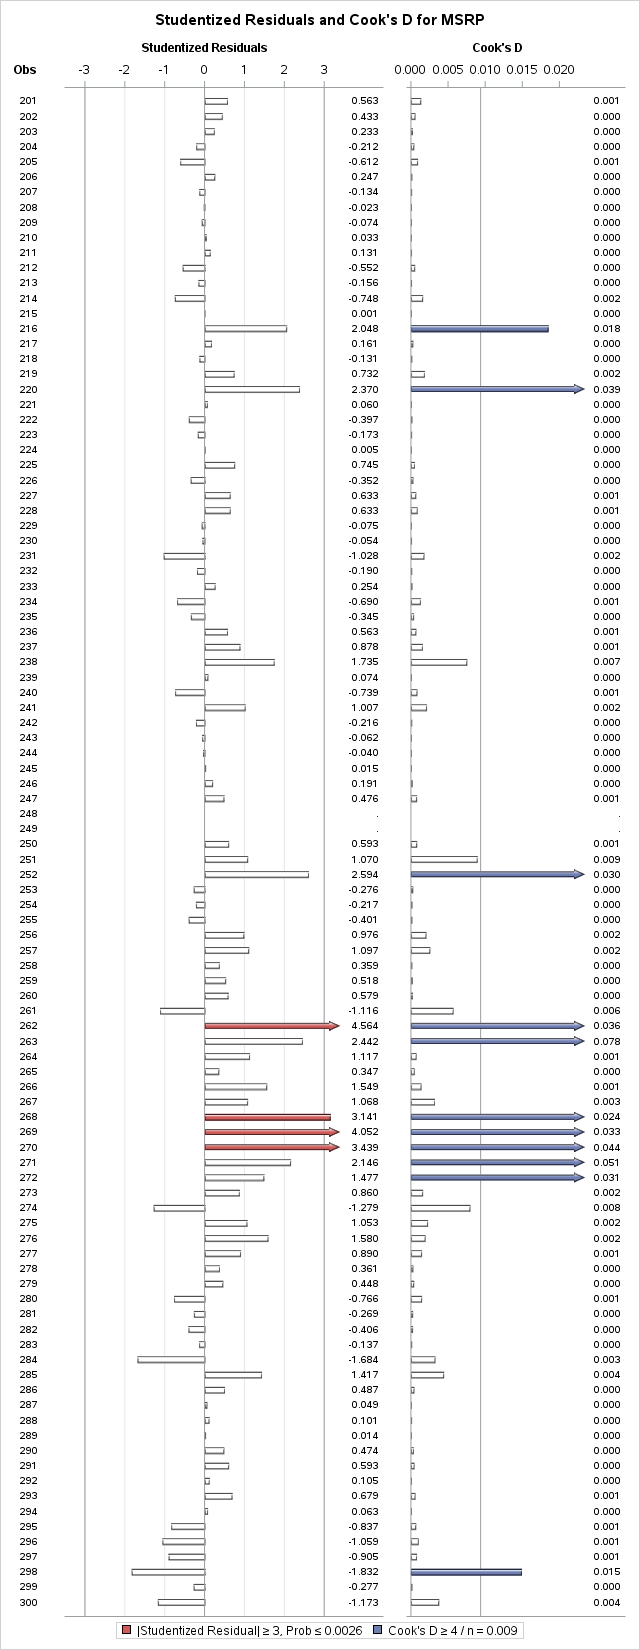
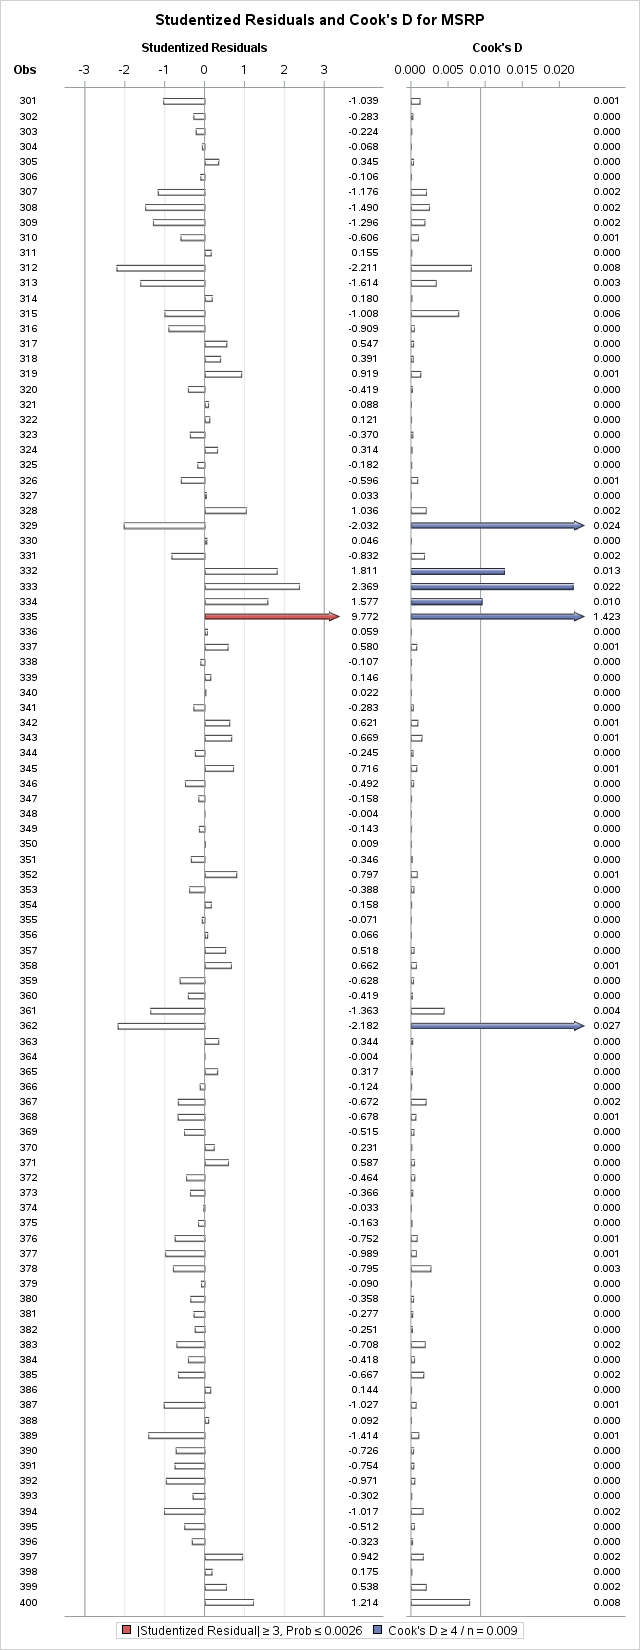
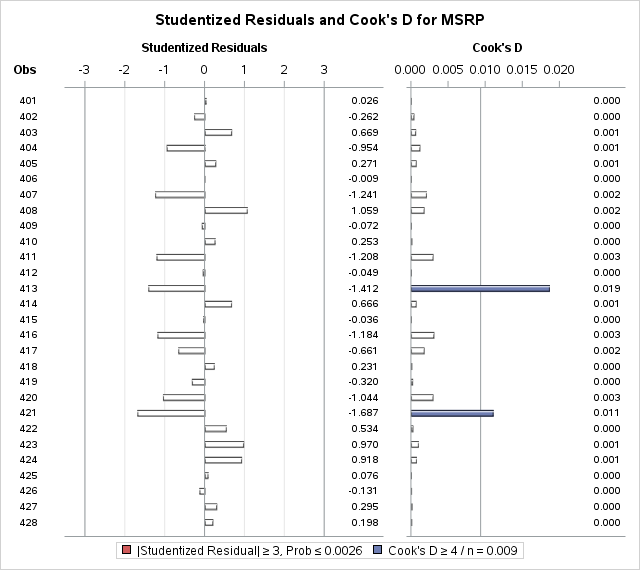
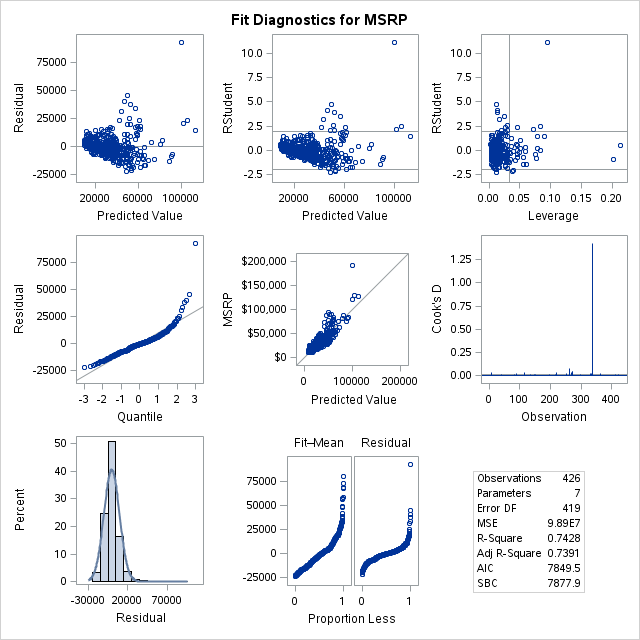
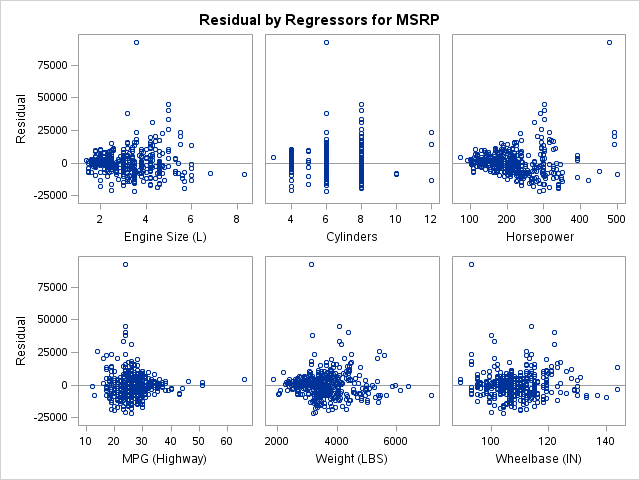

In [23]:
%%SAS
proc import datafile="dummy_data.csv"
     out= work.dummy_fsct_data
     dbms=csv
     replace;
run;

proc print data = work.dummy_fsct_data (obs=4) ;
run;

The next step is to generate forecasts. SAS provides a phenomenonal array of products - tools and solutions just for forecasting purposes.
***************
#### [SAS Forecast Analyst Workbench](http://www.sas.com/en_us/software/supply-chain/forecast-analyst-workbench.html)
* An **easy to use** modern GUI for delivering automated, high quality forecasts using sophosticated models - includes scheduling and scenario analysis
* Tight integration with the demand driven planning and optimization solution
* Unique patented approach for new product forecasting capability
* Ability to execute product chaining and set up business rules for product successions, phase-in/phase-outs etc.
***************
#### [SAS Forecast Server](http://www.sas.com/en_ph/software/analytics/forecastserver.html)
* A high performance forecasting engine for generating timely, quality forecasts using sophosticated models
* Automated and Scalable with advanced modelling capabilities
* Add Events and Causals very easily via an intituitive workflow
****************
#### [SAS Econometrics and Time Series](http://www.sas.com/en_us/software/analytics/ets.html)
* Model, forecast and simulate processes with econometric and time series analysis
* Includes ARIMA, ESM and other popular Time Series Modelling Techniques


*Please contact your friendly SAS representative for additional details on these products or [click here](http://www.sas.com/en_us/contact/form/register.html) to submit an online request*



In [24]:
%%SAS
proc esm data=work.dummy_fsct_data out=work.dummy_visits_fcst lead=6;
      id cal_date interval=month;
      forecast amazon_visits ebay_visits;
   run;


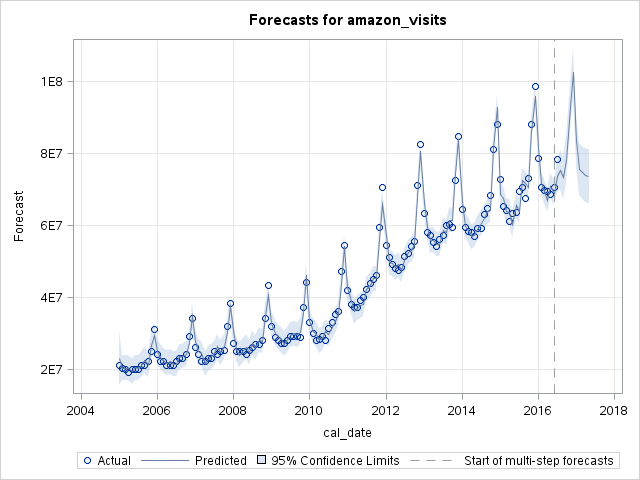
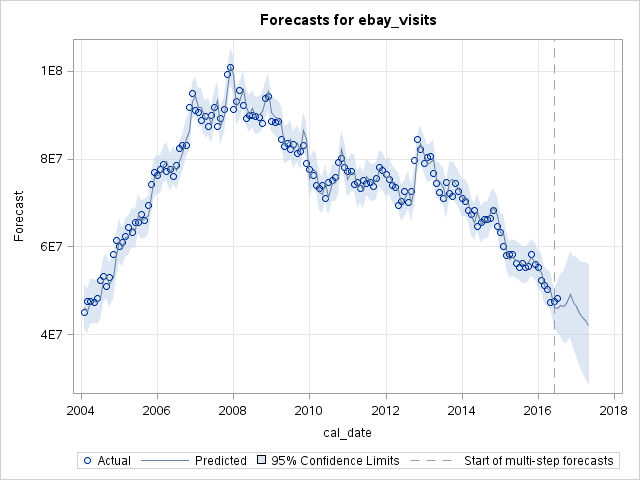

In [25]:
%%SAS
proc arima data=work.dummy_fsct_data plots
    (only)=(forecast(forecast )) 
        out=work.amz_dummy_visits_fcst;
    identify var=amazon_visits(12);
    estimate p=(1) (12) q= (12) method=ML;
    forecast lead=12 back=2 alpha=0.05 id=cal_date interval=month;
    outlier;
run;

proc arima data=work.dummy_fsct_data plots
    (only)=(forecast(forecast )) 
        out=work.ebay_dummy_visits_fcst;
    identify var=ebay_visits(1);
    estimate p=(1)(12) q= (12) method=ML;
    forecast lead=12 back=2 alpha=0.05 id=cal_date interval=month;
    outlier;
run;

proc sql;
create table work.dummy_visits_fcst  as
select a.cal_date, a.ebay_visits, a.forecast as ebay_forecasts,
b.amazon_visits,b.forecast as amazon_forecasts
from work.ebay_dummy_visits_fcst a inner join
work.amz_dummy_visits_fcst b
on a.cal_date = b.cal_date;
run;
quit;

In [28]:
result_loc = !find / -iname "dummy_visits_fcst*" 2>/dev/null ## Let's find where this file is at|

In [29]:
#!pip install sas7bdat -- this package needs to be installed to read SAS into pandas directly
#import sas7bdat -- import package before use

with sas7bdat.SAS7BDAT(result_loc[0]) as f:
    forecast_df = f.to_data_frame() # to import file into pandas as a data frame

[dummy_visits_fcst.sas7bdat] header length 65536 != 8192


Finally,let's tweak the dataset one last time & visualize the results!

In [30]:
forecast_df['vdate']=None
for i in range(len(forecast_df)):
    forecast_df['vdate'][i]=datetime.datetime.strftime(forecast_df['cal_date'][i],'%Y-%m-%d')
forecast_df.head()

,cal_date,ebay_visits,ebay_forecasts,amazon_visits,amazon_forecasts,vdate
0,2004-01-01,46178618.000,nan,18060282.000,nan,2004-01-01
1,2004-02-01,45088740.000,46289080.272,17097002.000,nan,2004-02-01
2,2004-03-01,47460506.000,45282815.974,17075225.000,nan,2004-03-01
3,2004-04-01,47446406.000,47413449.626,17063393.000,nan,2004-04-01
4,2004-05-01,47226070.000,47565545.072,17031637.000,nan,2004-05-01


In [31]:
forecast_df = forecast_df.set_index(forecast_df['vdate']) # set the calendar date as the index
forecast_df = forecast_df.drop('cal_date', axis= 1) #drop the redundant column
display_charts(forecast_df, title="Historical & Forecasted Visits",zoom="xy")